In [ ]:
import numpy as np 
import torch 
import torchvision as torchvision
import torch.nn as nn 
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline

In [ ]:
# Discriminator 
class Discriminator(nn.Module):
  def __init__(self, in_features):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(nn.Linear(in_features, 128),
                              nn.LeakyReLU(0.01),
                              nn.Linear(128, 1),
                              nn.Sigmoid())
  def forward(self, x):
    return self.disc(x)
# Generator 
class Generator(nn.Module): 
  def __init__(self, noise_dim, img_dim):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(nn.Linear(noise_dim, 256), 
                             nn.LeakyReLU(0.01), 
                             nn.Linear(256, img_dim), 
                             nn.Tanh())
  def forward(self, x):
    return self.gen(x)

In [ ]:
# hyper parameter
lr = 3e-4
epochs = 50 
batch_size = 32
img_dim = 28*28*1 
noise_dim = 64

In [ ]:
dis = Discriminator(in_features=img_dim)
gen = Generator(noise_dim=noise_dim, img_dim=img_dim)
crit = nn.BCELoss()
opt_dis = optim.Adam(dis.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)

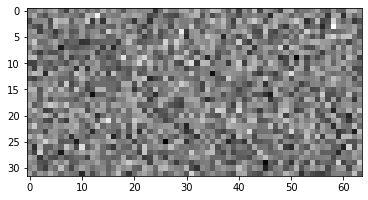

In [ ]:
# Generator input
fixed_noise = torch.randn((batch_size, noise_dim))
plt.imshow(fixed_noise, cmap='gray')
plt.show()

In [ ]:
# Discridata input 
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,)),])
dataset = torchvision.datasets.MNIST(root='/data', transform=trans, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
data, _ = next(iter(dataloader))  

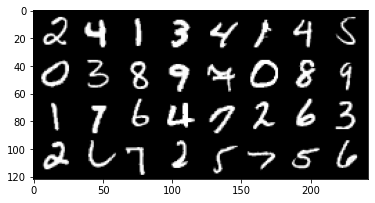

In [ ]:
img = data.reshape(-1, 1, 28, 28)
img = torchvision.utils.make_grid(img, normalize=True)
plt.imshow(img[0], cmap='gray')
plt.show()

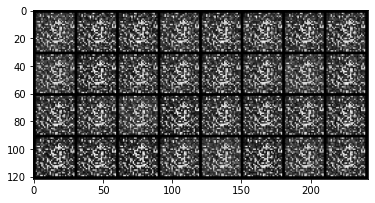

In [ ]:
for epoch in range(epochs):
  for i, (real, _) in enumerate(dataloader):
    real = real.view(-1, 784)
    batch_size = real.shape[0]

    ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
    # get discriminator loss for real 
    d_real = dis(real).view(-1)
    loss_d_real = crit(d_real, torch.ones_like(d_real))
    # get discriminator loss for fake 
    noise = torch.randn((batch_size, noise_dim))
    fake = gen(noise)
    d_fake = dis(fake).view(-1)
    loss_d_fake = crit(d_fake, torch.ones_like(d_fake))
    # calcualte loss and back propagate 
    loss_d = (loss_d_real + loss_d_fake)/2
    dis.zero_grad()
    loss_d.backward(retain_graph=True)
    opt_dis.step()


    ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
    output = dis(fake).view(-1)
    loss_g = crit(output, torch.ones_like(output))
    gen.zero_grad()
    loss_g.backward()
    opt_gen.step()

    if i == 0: 
      # img_real = real.reshape(-1,1,28,28)
      # img_grid_real = torchvision.utils.make_grid(img_real, normalize=True)
      img_fake_out = gen(fixed_noise).reshape(-1, 1, 28, 28)
      img_grid_fake = torchvision.utils.make_grid(img_fake_out, normalize=True)
      img_fake = img_grid_fake[0].detach().numpy()
      plt.imshow(img_fake, cmap='gray')
